In [1]:
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import math
import sh

IOSTAT_COLUMNS = ['Device:', 'rrqm/s', 'wrqm/s', 'r/s', 'w/s', 'rkB/s', 'wkB/s', 'avgrq-sz', 'avgqu-sz',
                  'await', 'r_await', 'w_await', 'svctm', '%util']
TEST_CONFIG = 'fixed-rate-submit'
DISK_CONFIG = 'ssd'

NJOBS = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
NDISKS = [1, 2, 4, 8]

DISKS = ['sdb', 'sdc', 'sdd', 'sde', 'sdf', 'sdg', 'sdh', 'sdi']

seaborn.set()
seaborn.set_context('talk')

jq = sh.jq.bake('-M', '-r')

def fio_iops_series(directory):
    iops = []
    for njobs in NJOBS:
        data = jq('.jobs[0].write.iops', '{:s}/fio-{:d}-jobs/fio.json'.format(directory, njobs))
        iops.append(float(data.strip()))
    return pd.Series(iops, NJOBS)

def fio_latency_series(directory):
    latency = []
    for njobs in NJOBS:
        data = jq('.jobs[0].write.lat_ns.mean', '{:s}/fio-{:d}-jobs/fio.json'.format(directory, njobs))
        latency.append(float(data.strip()))
    return pd.Series(latency, NJOBS)

def iostat_column_series(column, directory, ndisks):
    jobavgs = []
    for njobs in NJOBS:
        diskavgs = pd.Series()
        for disk in DISKS[0:ndisks]:
            data = pd.read_csv('{:s}/fio-{:d}-jobs/iostat-{:s}.txt'.format(directory, njobs, disk),
                               delim_whitespace=True, header=None, names=IOSTAT_COLUMNS, skiprows=5)
            diskavgs[disk] = data[column].mean()
        jobavgs.append(data[column].mean())
    return pd.Series(jobavgs, NJOBS)

def get_pctchange_dataframe(project, master):
    diff = pd.DataFrame()
    for plabel, mlabel in zip(project, master):
        new = project[plabel]
        old = master[mlabel]
        diff[plabel.replace('project - ', '')] = 100 * ((new - old) / old)
    return diff

def plot_iops_dataframe(df):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('fio -- write iops vs. fio threads')
    plt.xlabel('number of fio threads issuing writes')
    plt.ylabel('write iops reported by fio')
    plt.loglog(basey=2)
    plt.xticks(df.index, df.index)
    plt.show()

def plot_latency_dataframe(df):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('fio -- average write latency vs. fio threads')
    plt.xlabel('number of fio threads issuing writes')
    plt.ylabel('average write latency reported by fio (microseconds)')
    plt.loglog(basey=2)
    plt.xticks(df.index, df.index)
    plt.show()

def plot_iostat_column_dataframe(df, column):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('iostat -- {:s} vs. fio threads'.format(column))
    plt.xlabel('number of fio threads issuing writes')
    plt.xscale('log')
    plt.xticks(df.index, df.index)
    plt.show()

In [2]:
master_latency = pd.DataFrame()
master_iops = pd.DataFrame()
master_busy = pd.DataFrame()
for i in NDISKS:
    directory = 'zfsonlinux-6566-perf/{:s}/master/{:d}-{:s}'.format(TEST_CONFIG, i, DISK_CONFIG)
    label = 'master - {:d} {:s}'.format(i, DISK_CONFIG)
    master_latency[label] = fio_latency_series(directory)
    master_iops[label] = fio_iops_series(directory)
    master_busy[label] = iostat_column_series('%util', directory, i)

project_latency = pd.DataFrame()
project_iops = pd.DataFrame()
project_busy = pd.DataFrame()
for i in NDISKS:
    directory = 'zfsonlinux-6566-perf/{:s}/project/{:d}-{:s}'.format(TEST_CONFIG, i, DISK_CONFIG)
    label = 'project - {:d} {:s}'.format(i, DISK_CONFIG)
    project_latency[label] = fio_latency_series(directory)
    project_iops[label] = fio_iops_series(directory)
    project_busy[label] = iostat_column_series('%util', directory, i)

pctchange_latency = get_pctchange_dataframe(project_latency, master_latency)
pctchange_iops = get_pctchange_dataframe(project_iops, master_iops)

# ZFS on Linux #6566 Performance Results - Fixed Rate Submit on SSDs

### Workload Details

This workload consisted of using `fio` to drive synchronous writes, while varying the number of threads used by `fio`. Each `fio` thread would issue writes to a unique file, using sequential file offsets, `pwrite`, `O_SYNC`, a blocksize of `8k`, and a queue depth of 1 (i.e. each thread performing a single write at a time). Additionally, each thread would attempt to acheive a bandwidth of about 64 writes per second; i.e. after a write completes, the thread may artficially delay, such that it doesn't exceed its target of 64 write operations per second. Here's the `fio` configuration used to acheive this:
```
[global]
group_reporting
clocksource=cpu
ioengine=psync
fallocate=none
blocksize=8k
runtime=60
time_based
iodepth=1
rw=write
thread=0
direct=0
sync=1

# Real world random request flow follows Poisson process. To give better
# insight on latency distribution, we simulate request flow under Poisson
# process.
rate_process=poisson
rate_iops=64

[zfs-workload]
```

The command line flag `--numjobs` was used to vary the number of threads used for each invocation, ranging from a single thread to 1024 threads.

### ZFS Pool and Dataset Configuration

The above `fio` workload was run on zpools with varying numbers of direct attached disks; configurations of 1 disk, 2 disks, 4 disks, and 8 disks were used. All configuration options were kept default at the zpool level (i.e. no `-o` options were passed to `zpool create`).

For all tests, a single ZFS dataset was used to store all the `fio` files for all thread counts. The configuration options used for this dataset were the following: `recsize=8k`, `compress=lz4`, `checksum=edonr`, `redundant_metadata=most`. These were all chosen to match the options used by our Delphix Engine, except `recsize`, which was used to avoid the read-modify-write penalty since `fio` was issuing `8k` writes.

### System Hardware Configuration
 
 - VM running on VMWare ESXi 6.0.0
 - 32 vCPUs
 - 512 GB of RAM
 - Enterprise Solid State Disks

## IOPs as reported by `fio` vs. number of `fio` threads

Below are graphs of the write IOPs reported by `fio` (using the `write.iops` metric), which accounts for all `fio` threads in the given run; i.e. it's the aggregate value for all `fio` threads vs. the value of each individual `fio` thread. Additionally, each line corresponds to a different zpool configuration; each configuration having a different number of disks in the pool.

### IOPs as reported by `fio` vs. number of `fio` threads - master branch

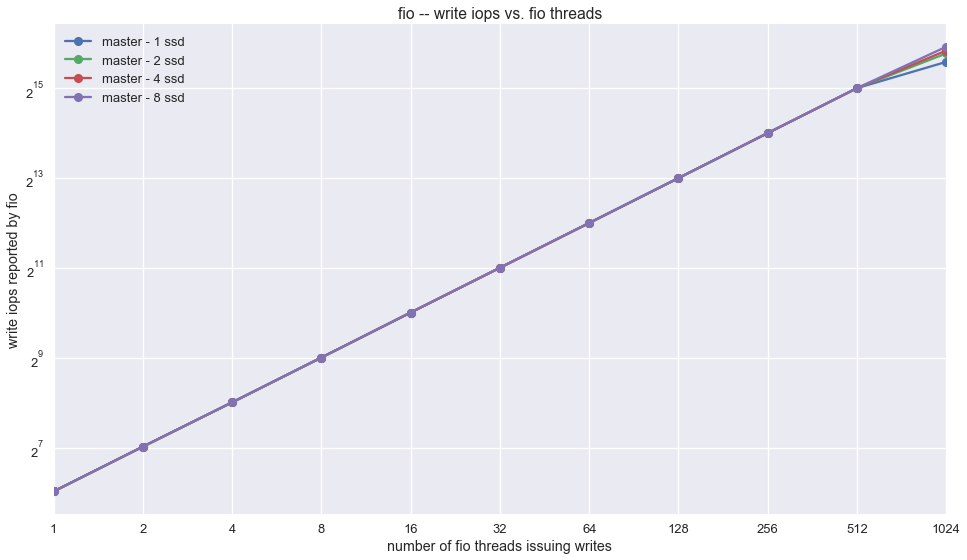

In [3]:
plot_iops_dataframe(master_iops)

In [4]:
master_iops

,master - 1 ssd,master - 2 ssd,master - 4 ssd,master - 8 ssd
1,65.108764,65.108764,65.108764,65.108764
2,129.934375,129.934375,129.934375,129.934375
4,257.353676,257.353676,257.353676,257.353676
8,513.840773,513.840773,513.840773,513.824117
16,1028.756973,1028.859765,1028.876898,1028.876898
32,2053.124167,2053.124167,2053.124167,2053.124167
64,4096.298515,4096.298515,4096.298515,4096.298515
128,8192.604186,8189.584582,8189.584582,8189.584582
256,16400.592632,16397.510152,16397.510152,16401.681512
512,32802.096855,32803.494758,32804.759527,32806.107505


### IOPs as reported by `fio` vs. number of `fio` threads - project branch

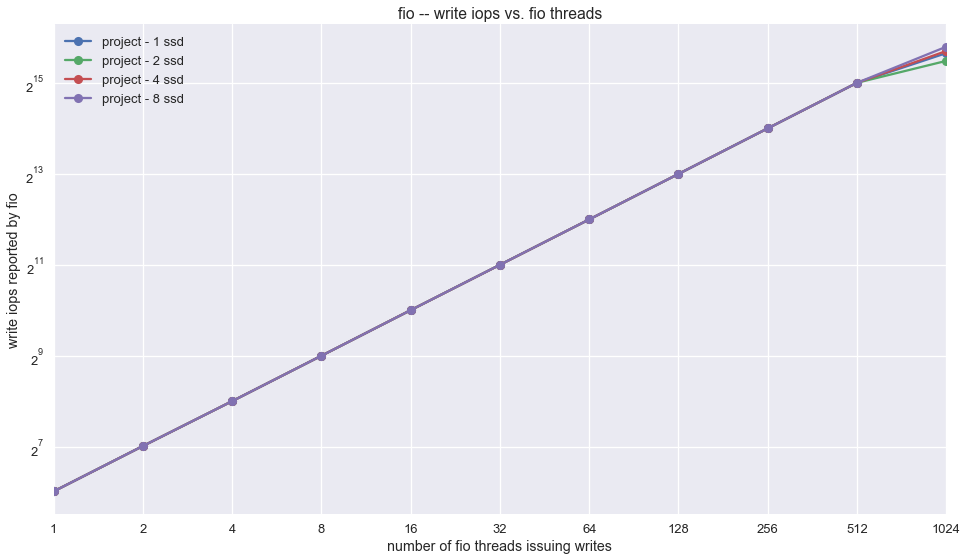

In [5]:
plot_iops_dataframe(project_iops)

In [6]:
project_iops

,project - 1 ssd,project - 2 ssd,project - 4 ssd,project - 8 ssd
1,65.108764,65.108764,65.108764,65.108764
2,129.934375,129.934375,129.934375,129.934375
4,257.353676,257.353676,257.353676,257.353676
8,513.840773,513.840773,513.824117,513.840773
16,1028.859765,1028.876898,1028.843592,1028.826938
32,2053.124167,2053.124167,2052.033712,2053.124167
64,4096.281872,4096.298515,4096.298515,4096.298515
128,8189.551295,8189.584582,8189.584582,8189.567938
256,16397.260502,16397.526796,16397.526796,16397.526796
512,32805.844469,32806.273922,32806.373773,32804.143784


## % change in write IOPs vs. number of `fio` threads - master vs. project

The following graph shows the percentage change for the IOPs reported by `fio`, between the "master" and "project" test runs. A positive value here reflects an increase in the IOPs reported by fio when comparing the results of the "project" branch to the "master" branch; i.e. positive is better. Additionally, a 100% increase would reflect a doubling of the IOPs. Similarly, a 50% decrease would equate to halving the IOPs.

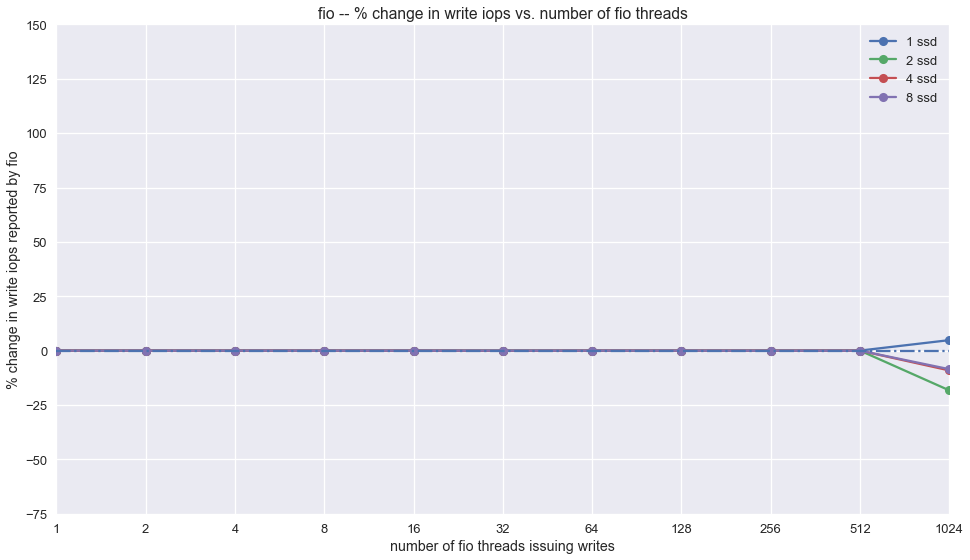

In [7]:
pctchange_iops.plot(figsize=(16, 9), style='-o')
plt.title('fio -- % change in write iops vs. number of fio threads')
plt.xlabel('number of fio threads issuing writes')
plt.ylabel('% change in write iops reported by fio')
plt.ylim(-75, 150)
plt.xscale('log')
plt.xticks(pctchange_iops.index, pctchange_iops.index)
plt.axhline(0, ls='-.')
plt.show()

In [8]:
pctchange_iops

,1 ssd,2 ssd,4 ssd,8 ssd
1,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,-0.003241,0.003242
16,0.009992,0.001665,-0.003237,-0.004856
32,0.000000,0.000000,-0.053112,0.000000
64,-0.000406,0.000000,0.000000,0.000000
128,-0.037264,0.000000,0.000000,-0.000203
256,-0.020317,0.000102,0.000102,-0.025331
512,0.011425,0.008472,0.004921,-0.005986


## average write latency as reported by `fio` vs. number of `fio` threads

Below are graphs of the average write latency (in microseconds) reported by `fio` (using the `write.lat.mean` metric), for all `fio` threads in the test run. Just like the graph of IOPs above, each line represents a different zpool configuration, and there's data for the "master" branch as well as the "project" branch.

## average write latency as reported by `fio` vs. number of `fio` threads - maser branch

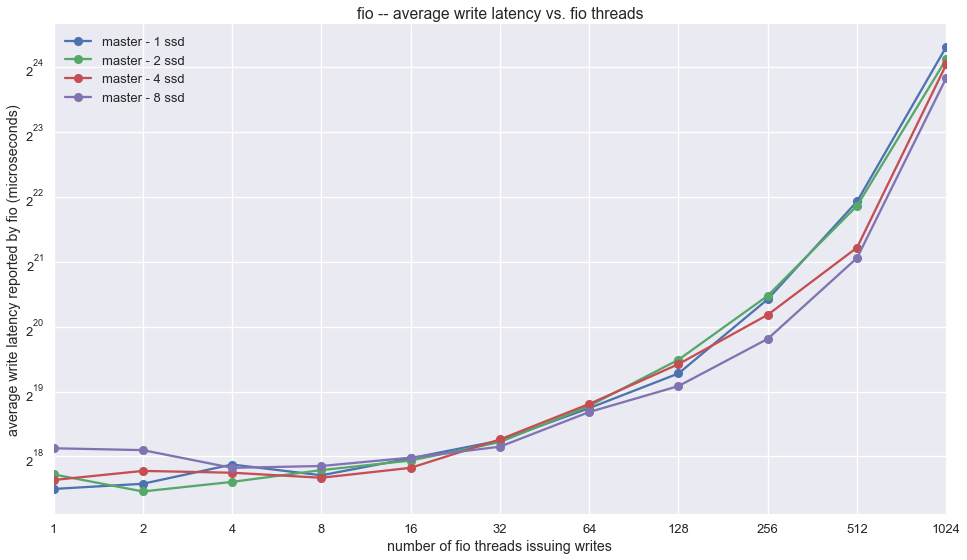

In [9]:
plot_latency_dataframe(master_latency)

In [10]:
master_latency

,master - 1 ssd,master - 2 ssd,master - 4 ssd,master - 8 ssd
1,1.854027e+05,2.165291e+05,2.039736e+05,2.862139e+05
2,1.959188e+05,1.805108e+05,2.247842e+05,2.806037e+05
4,2.406234e+05,1.999228e+05,2.204599e+05,2.322418e+05
8,2.144698e+05,2.267006e+05,2.089155e+05,2.368574e+05
16,2.572558e+05,2.510367e+05,2.322974e+05,2.589944e+05
32,3.107226e+05,3.057739e+05,3.145104e+05,2.910821e+05
64,4.391913e+05,4.496428e+05,4.592656e+05,4.213501e+05
128,6.358156e+05,7.363899e+05,7.024727e+05,5.557962e+05
256,1.404593e+06,1.457931e+06,1.189545e+06,9.200950e+05
512,3.985981e+06,3.804154e+06,2.435985e+06,2.181578e+06


### average write latency as reported by `fio` vs. number of `fio` threads - project branch

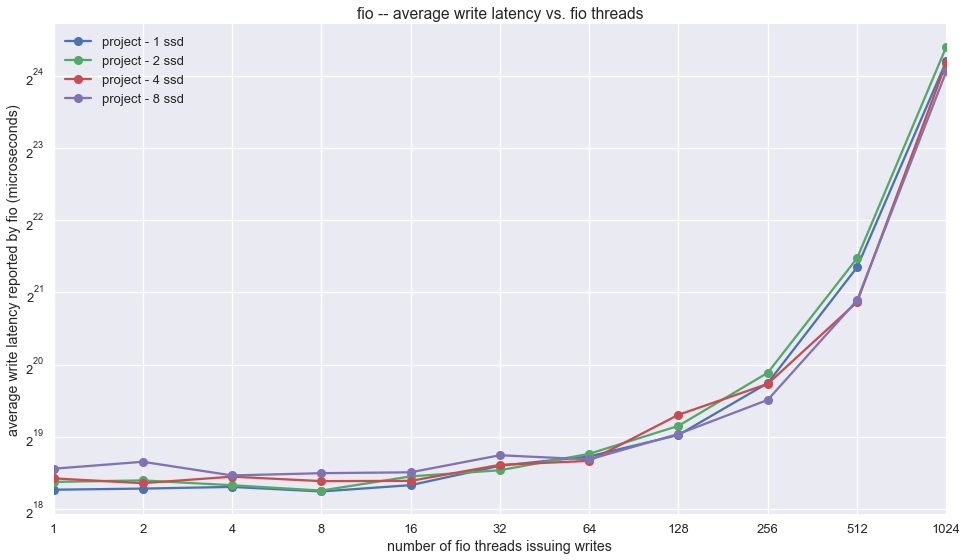

In [11]:
plot_latency_dataframe(project_latency)

In [12]:
project_latency

,project - 1 ssd,project - 2 ssd,project - 4 ssd,project - 8 ssd
1,3.153378e+05,3.398635e+05,3.516919e+05,3.858049e+05
2,3.187628e+05,3.448677e+05,3.358050e+05,4.123821e+05
4,3.239453e+05,3.291421e+05,3.575062e+05,3.616894e+05
8,3.101132e+05,3.127551e+05,3.424560e+05,3.696241e+05
16,3.295210e+05,3.584308e+05,3.432815e+05,3.727779e+05
32,3.969471e+05,3.802072e+05,4.004022e+05,4.391642e+05
64,4.341196e+05,4.452267e+05,4.161043e+05,4.217907e+05
128,5.336109e+05,5.824235e+05,6.477655e+05,5.389101e+05
256,8.782380e+05,9.701395e+05,8.716868e+05,7.472968e+05
512,2.670723e+06,2.912596e+06,1.911840e+06,1.943695e+06


## % change in average write latency vs. number of `fio` threads -  master vs. project

The following graph shows the percentage change for the average write latency reported by `fio`, between the "master" branch and "project" branch test runs. A positive value here reflects an increase in the average write latency reported by `fio` when comparing the "project" to the "baseline". Thus, unlike the IOPs numbers above, a negative value here is better.

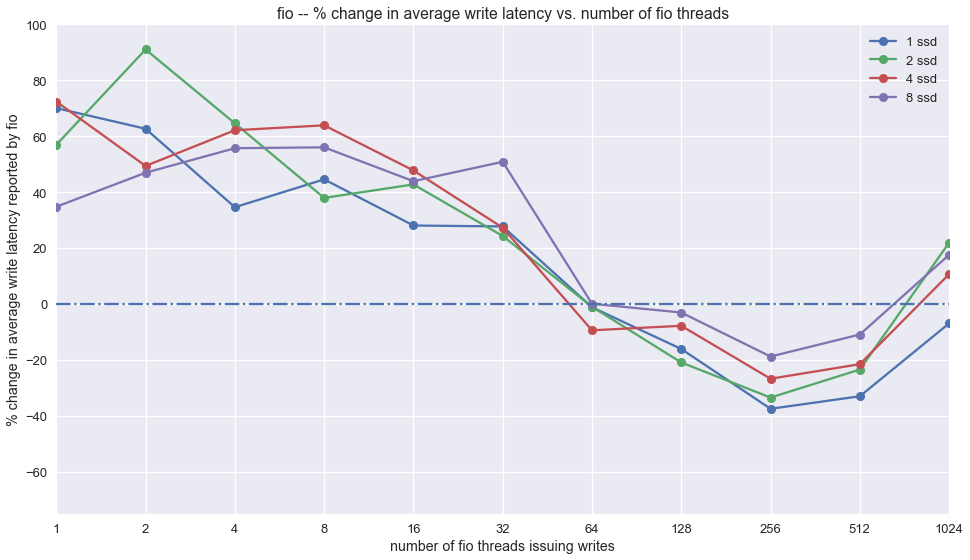

In [13]:
pctchange_latency.plot(figsize=(16, 9), style='-o')
plt.title('fio -- % change in average write latency vs. number of fio threads')
plt.xlabel('number of fio threads issuing writes')
plt.ylabel('% change in average write latency reported by fio')
plt.ylim(-75, 100)
plt.xscale('log')
plt.xticks(pctchange_latency.index, pctchange_latency.index)
plt.axhline(0, ls='-.')
plt.show()

In [14]:
pctchange_latency

,1 ssd,2 ssd,4 ssd,8 ssd
1,70.082626,56.959756,72.420322,34.796019
2,62.701536,91.050972,49.389954,46.962440
4,34.627529,64.634592,62.163822,55.738274
8,44.595291,37.959517,63.920832,56.053399
16,28.090791,42.780251,47.776767,43.932826
32,27.749695,24.342599,27.309687,50.872949
64,-1.154789,-0.982125,-9.397892,0.104588
128,-16.074574,-20.908279,-7.787807,-3.038179
256,-37.473823,-33.457809,-26.720962,-18.780469
512,-32.997083,-23.436421,-21.516751,-10.904190


## `%util` averaged across all disks in zpool vs. `fio` threads

Below are graphs of the `%util` column from `iostat` for all disks in the zpool.

The values that're shown were generating by using 1 second samples (i.e. `iostat -x 1`) for each disk in the zpool, for the entire runtime of the test. These samples were then averaged to acheive a single `%util` average for each disk in the zpool. Then, the single value per disk was averaged across all disks in the zpool, to achieve a single `%util` value, representing all disks in the zpool.

This provides an approximation for how utilized the disks in the zpool were, during the runtime of the `fio` workload.

### `%util` averaged across all disks in zpool vs. `fio` threads - master branch

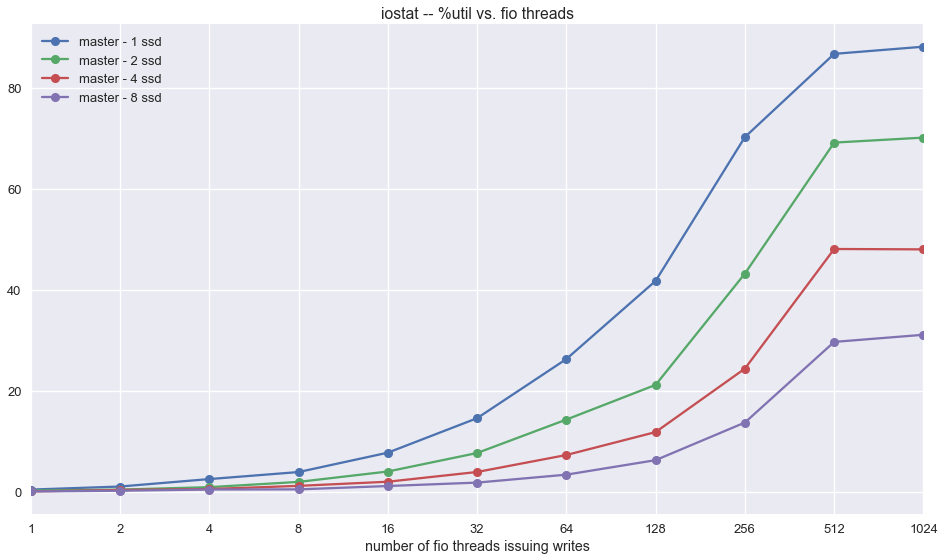

In [15]:
plot_iostat_column_dataframe(master_busy, '%util')

In [16]:
master_busy

,master - 1 ssd,master - 2 ssd,master - 4 ssd,master - 8 ssd
1,0.487273,0.298182,0.130909,0.116364
2,1.090909,0.487273,0.407273,0.254545
4,2.567273,0.967273,0.596364,0.501818
8,3.956364,2.007273,1.221818,0.530909
16,7.789091,4.065455,2.043636,1.192727
32,14.610909,7.723636,3.970909,1.869091
64,26.320000,14.341818,7.330909,3.440000
128,41.789273,21.207273,11.869091,6.312727
256,70.243455,43.236000,24.429091,13.757455
512,86.712727,69.152545,48.098545,29.712182


### `%util` averaged across all disks in zpool vs. `fio` threads - project branch

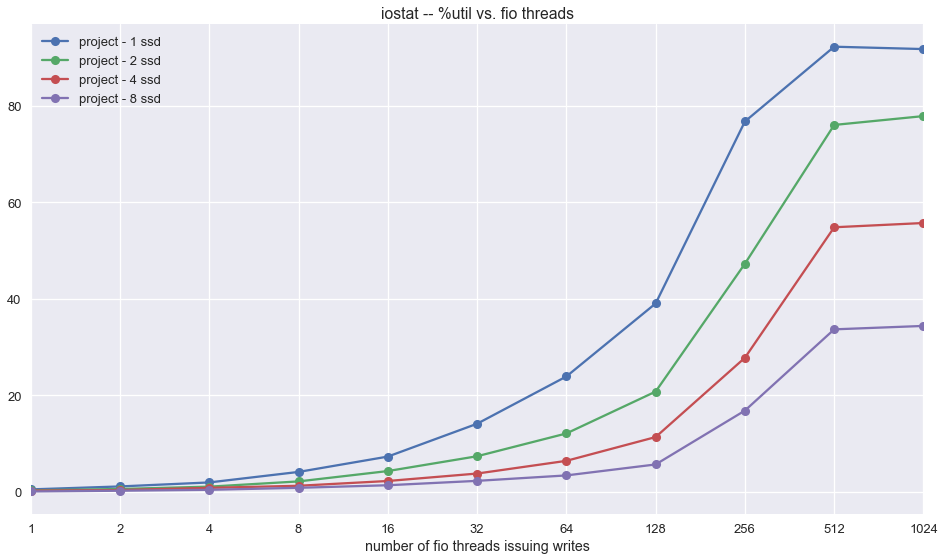

In [17]:
plot_iostat_column_dataframe(project_busy, '%util')

In [18]:
project_busy

,project - 1 ssd,project - 2 ssd,project - 4 ssd,project - 8 ssd
1,0.545455,0.341818,0.283636,0.116364
2,1.156364,0.632727,0.407273,0.269091
4,1.985455,1.112727,0.865455,0.458182
8,4.160000,2.196364,1.294545,0.872727
16,7.338182,4.341091,2.283636,1.403636
32,14.138182,7.409091,3.825455,2.312727
64,23.927273,12.128364,6.458182,3.439091
128,39.047273,20.800000,11.381818,5.709091
256,76.736364,47.281455,27.805818,16.865455
512,92.225455,76.020909,54.829636,33.689636
